# Initialization

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from matplotlib import gridspec

from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn.model_selection import train_test_split

from pandas import Grouper

In [2]:
train_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

train=pd.read_csv(train_url, compression='gzip')

# Data exploration

In [3]:
train.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [4]:
train.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
train.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
35418,None,294.23,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2017-07-17 23:00:00,1016
19643,None,279.87,0.0,0.0,1,Clear,sky is clear,2015-11-23 15:00:00,5706
48170,None,281.44,0.0,0.0,90,Clouds,overcast clouds,2018-09-29 17:00:00,4878
47415,None,295.01,1.6,0.0,90,Drizzle,drizzle,2018-09-04 17:00:00,5494
42548,None,277.62,0.0,0.0,40,Clouds,scattered clouds,2018-03-22 15:00:00,5963


In [6]:
train.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

# Data cleanup

In [7]:
train.date_time = pd.to_datetime(train.date_time,infer_datetime_format=True)
train.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

# Visualize the data

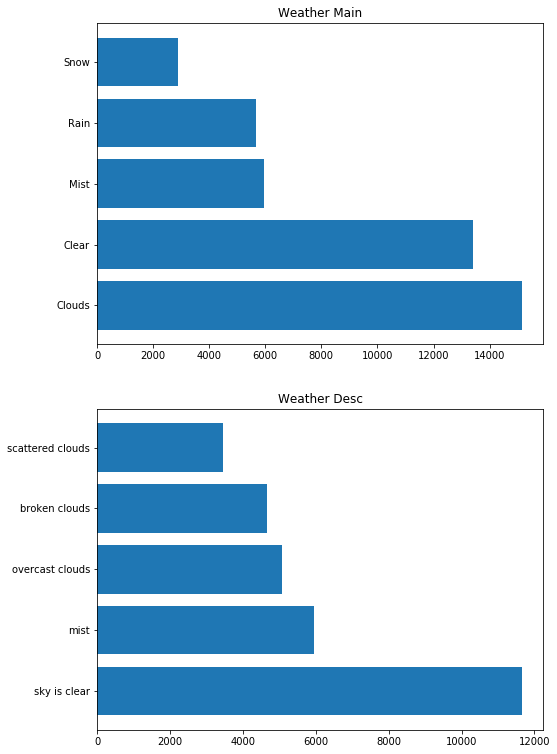

In [8]:
plt.figure(figsize=(8, 13))
plt.subplot(211)
df=train.weather_main.value_counts().head(5)
plt.barh(df.index, df)
plt.title('Weather Main')
df=train.weather_description.value_counts().head(5)
plt.subplot(212)
plt.barh(df.index, df)
plt.title('Weather Desc')
#plt.subplots_adjust(hspace=0.5)
plt.show()


Text(0.5, 0.98, 'Traffic distribution over holidays')

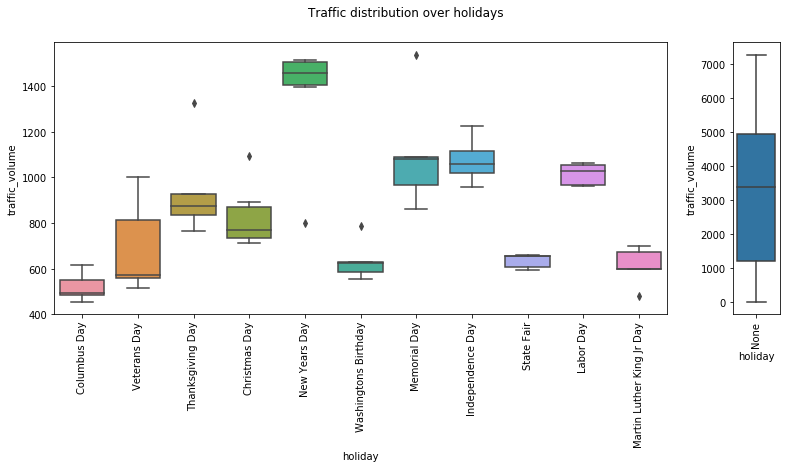

In [9]:
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(13,5))
# set up subplot grid
#gridspec.GridSpec(15, 12)

rows=1
columns=13 # 11 holidays + 1 no holiday (None) + 1 for labels
# large subplot
plt.subplot2grid((rows,columns), (0,0), colspan=11, rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] != "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)

# small subplot
plt.subplot2grid((rows,columns), (0, columns-1), rowspan=rows)
ax=sns.boxplot(
    x='holiday',
    y='traffic_volume',
    data=train[train["holiday"] == "None"],
)
plt.setp(ax.get_xticklabels(), rotation=90)

fig.suptitle("Traffic distribution over holidays")

Traffic pattern during the day


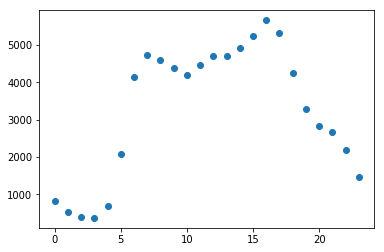

In [10]:
print("Traffic pattern during the day")
df = train.groupby(train.date_time.dt.hour).mean()
plt.scatter(df.index, df.traffic_volume)
plt.show()

Traffic pattern over time


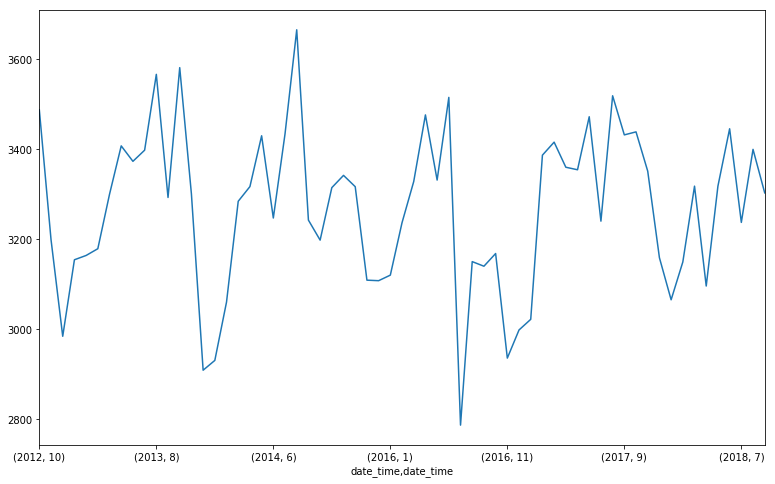

In [11]:
print("Traffic pattern over time")
fig, ax = plt.subplots(figsize=(13,8))
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].plot(ax=ax)

In [12]:
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].unstack()

date_time,1,2,3,4,5,6,7,8,9,10,11,12
date_time,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3486.740373,3198.431847,2983.665635
2013,3153.654391,3163.216179,3178.204196,3299.192758,3406.630851,3372.327249,3397.068182,3565.536923,3292.039749,3580.423077,3299.594915,2908.321226
2014,2930.078780,3059.722963,3283.589431,3316.219118,3429.088689,3246.413437,3433.305471,3664.544118,NaN,NaN,NaN,NaN
2015,NaN,NaN,NaN,NaN,NaN,3241.736559,3197.291715,3313.879070,3341.111111,3315.996497,3108.342213,3107.174957
2016,3119.504146,3235.977273,3327.467105,3475.434839,3330.711732,3514.357625,2786.311275,3149.538741,3139.309554,3167.510316,2935.204290,2997.709091
2017,3021.324561,3386.042017,3414.931792,3359.195223,3353.585084,3471.363525,3239.432941,3517.937500,3431.079503,3437.757543,3350.451422,3158.147560
2018,3064.751131,3148.782338,3317.182238,3095.325942,3317.254879,3444.641876,3236.646651,3398.878436,3302.213904,NaN,NaN,NaN


Traffic pattern over time, stacked on years


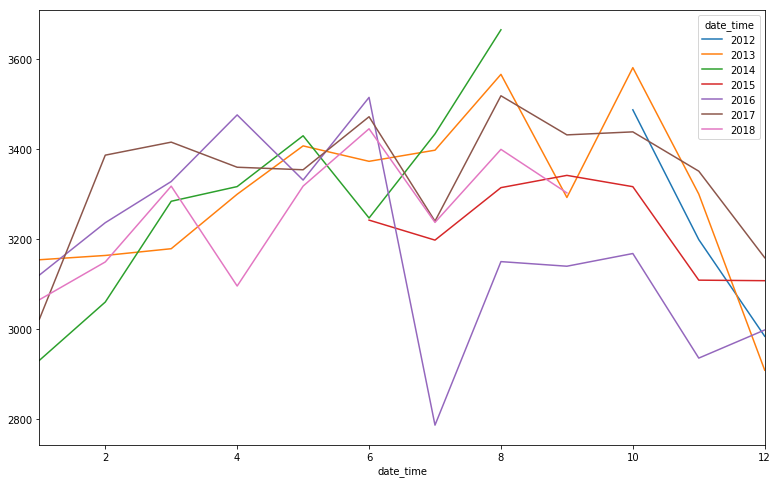

In [13]:
print("Traffic pattern over time, stacked on years")
fig, ax = plt.subplots(figsize=(13,8))
train.groupby([train.date_time.dt.month, train.date_time.dt.year]).mean()['traffic_volume'].unstack().plot(ax=ax)

Traffic pattern over time, stacked on months


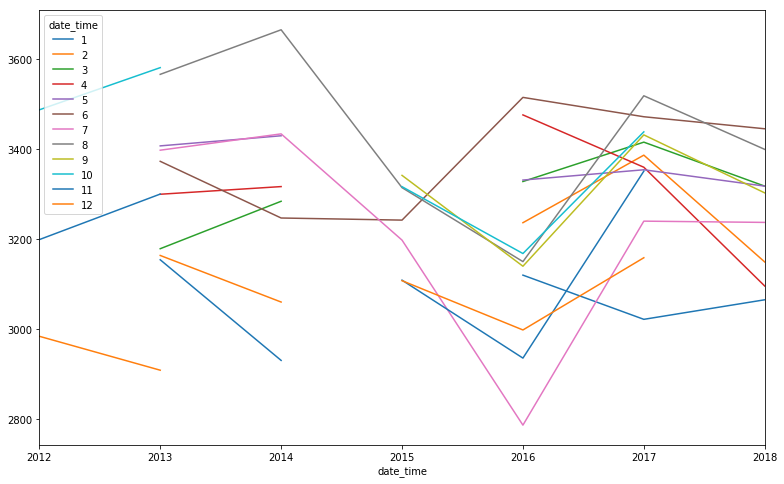

In [14]:
print("Traffic pattern over time, stacked on months")
fig, ax = plt.subplots(figsize=(13,8))
train.groupby([train.date_time.dt.year, train.date_time.dt.month]).mean()['traffic_volume'].unstack().plot(ax=ax)

# Feature engineering

Create numerical columns representing categorical data.

In [15]:
train.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [16]:
train['isHoliday'] = np.where(train.holiday == 'None', False, True)

In [17]:
train.weather_main.unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [18]:
train['weather_main_num'] = train.weather_main.map({
        '?':0, 'Clouds':10, 'Clear':20, 'Rain':30, 'Drizzle':40, 
        'Mist':50, 'Haze':60, 'Fog':70, 'Thunderstorm':80, 
        'Snow':90, 'Squall':100, 'Smoke':110
    })

In [19]:
train.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [20]:
train['weather_description'] = np.where(train.weather_description == 'Sky is Clear', 'sky is clear', 
                                        train.weather_description)

In [21]:
train['weather_description_num'] = train.weather_description.map({
        '?':0, 'scattered clouds':11, 'broken clouds':12, 'overcast clouds':13,
       'sky is clear':21, 'few clouds':14, 'light rain':31,
       'light intensity drizzle':41, 'mist':51, 'haze':61, 'fog':71,
       'proximity shower rain':32, 'drizzle':42, 'moderate rain':33,
       'heavy intensity rain':34, 'proximity thunderstorm':81,
       'thunderstorm with light rain':82, 'proximity thunderstorm with rain':83,
       'heavy snow':91, 'heavy intensity drizzle':43, 'snow':92,
       'thunderstorm with heavy rain':84, 'freezing rain':93, 'shower snow':94,
       'light rain and snow':35, 'light intensity shower rain':36, 'SQUALLS':100,
       'thunderstorm with rain':85, 'proximity thunderstorm with drizzle':86,
       'thunderstorm':87, 'Sky is Clear':22, 'very heavy rain':37,
       'thunderstorm with light drizzle':88, 'light snow':95,
       'thunderstorm with drizzle':89, 'smoke':111, 'shower drizzle':43,
       'light shower snow':96, 'sleet':97
    })

In [22]:
df=train[['weather_description_num', 'weather_description']]
df=df.sort_values(by='weather_description_num')

Text(0.5, 1.0, 'Traffic distribution over weather')

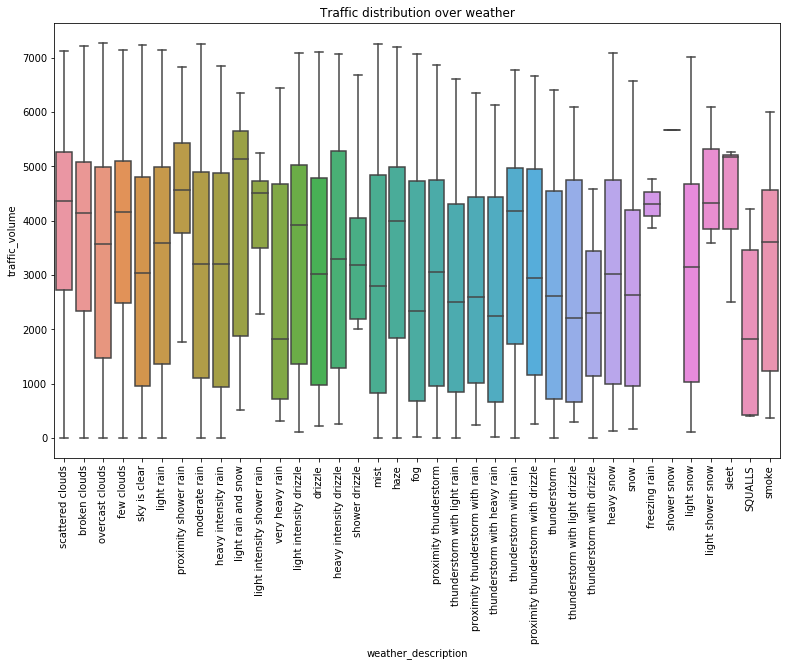

In [23]:
plt.figure(figsize=(13, 8))

ax=sns.boxplot(
    x='weather_description',
    y='traffic_volume',
    order=df.weather_description.unique(),
    data=train,
)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title("Traffic distribution over weather")

In [24]:
holiday_weather = train[train['isHoliday']]

Text(0.5, 1.0, 'Traffic distribution on holidays over weather')

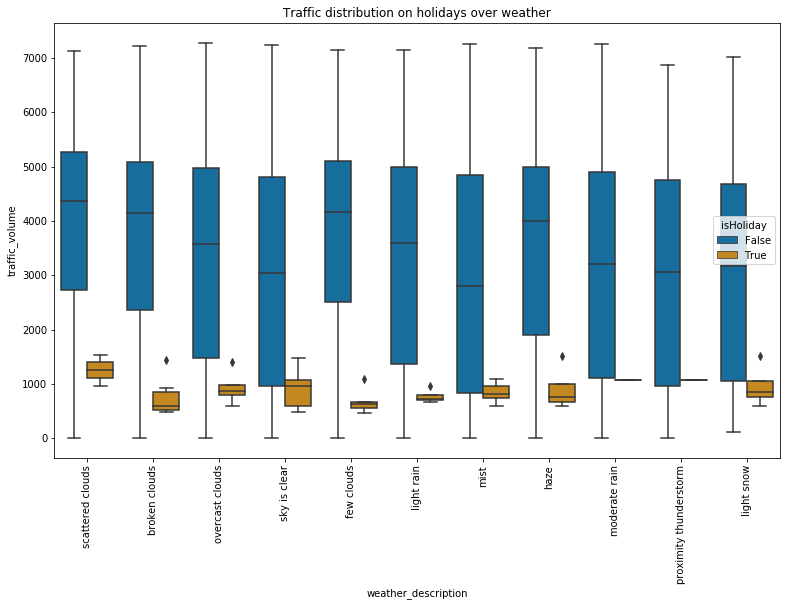

In [25]:
f = (train
         .loc[:, ['weather_description', 'traffic_volume', 'isHoliday']]
    )

f = f[f['weather_description'].isin(holiday_weather.weather_description.unique())]

plt.figure(figsize=(13, 8))
sns.set_palette("colorblind")
ax=sns.boxplot(x="weather_description"
            , y="traffic_volume"
            , hue='isHoliday'
            , data=f)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title("Traffic distribution on holidays over weather")